In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = r"C:\Users\leopo\OneDrive\Bureau\UNITY\cell_images"
parasitized_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

# Count images
n_parasitized = len([f for f in os.listdir(parasitized_dir) if f.endswith('.png')])
n_uninfected = len([f for f in os.listdir(uninfected_dir) if f.endswith('.png')])

print(f"Parasitized: {n_parasitized}")
print(f"Uninfected: {n_uninfected}")
print(f"Total: {n_parasitized + n_uninfected}")

Parasitized: 13779
Uninfected: 13779
Total: 27558


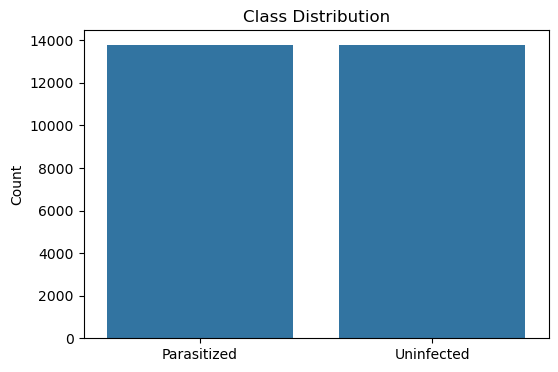

In [3]:
plt.figure(figsize=(6,4))
sns.barplot(x=['Parasitized', 'Uninfected'], y=[n_parasitized, n_uninfected])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.show()

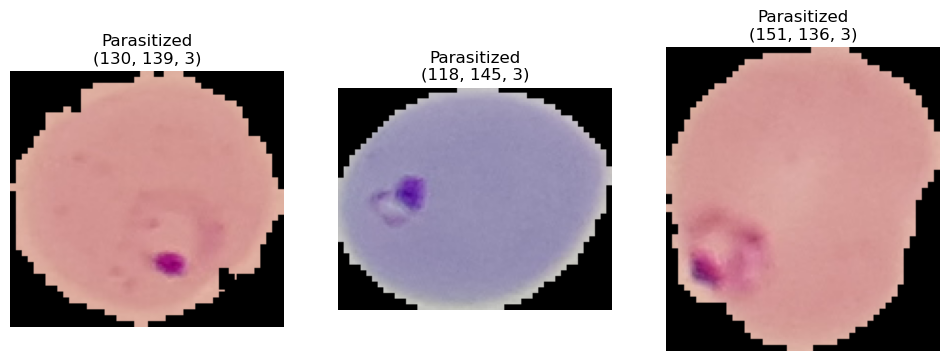

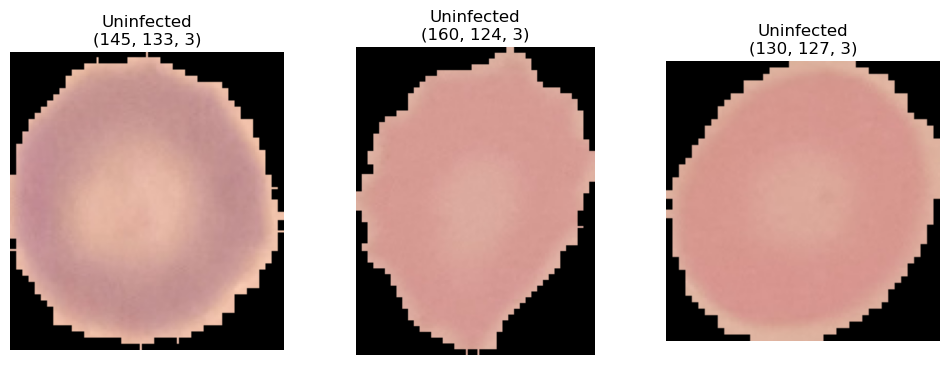

In [4]:
def inspect_random_images(class_dir, n=3):
    files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
    samples = np.random.choice(files, n)
    plt.figure(figsize=(12, 4))
    for i, f in enumerate(samples):
        img_path = os.path.join(class_dir, f)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img_rgb)
        plt.title(f"{os.path.basename(class_dir)}\n{img.shape}")
        plt.axis('off')
    plt.show()

inspect_random_images(parasitized_dir)
inspect_random_images(uninfected_dir)

In [5]:
def get_image_shapes(class_dir):
    shapes = []
    for f in os.listdir(class_dir)[:100]:  # sample 100
        if f.endswith('.png'):
            img = cv2.imread(os.path.join(class_dir, f))
            if img is not None:
                shapes.append(img.shape)
    return shapes

par_shapes = get_image_shapes(parasitized_dir)
un_shapes = get_image_shapes(uninfected_dir)

all_shapes = par_shapes + un_shapes
heights = [s[0] for s in all_shapes]
widths = [s[1] for s in all_shapes]

print(f"Min H: {min(heights)}, Max H: {max(heights)}")
print(f"Min W: {min(widths)}, Max W: {max(widths)}")

Min H: 79, Max H: 217
Min W: 85, Max W: 199


In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pathlib

# Set constants
IMG_SIZE = 128  # or 224 if using pre-trained models later
BATCH_SIZE = 32

# Use Keras utility to load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',  # since binary classification
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="training"
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="validation"
)

# Further split val into val + test
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 2)
val_dataset = val_dataset.skip(val_batches // 2)

# Normalize: [0,255] → [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = dataset.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 27558 files belonging to 2 classes.
Using 19291 files for training.
Found 27558 files belonging to 2 classes.
Using 8267 files for validation.


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

model.summary()

C:\Users\leopo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stop]
)

Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.7448 - loss: 0.5051 - precision: 0.7246 - recall: 0.7864 - val_accuracy: 0.9164 - val_loss: 0.2518 - val_precision: 0.8719 - val_recall: 0.9790
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 552s 861ms/step - accuracy: 0.9222 - loss: 0.2694 - precision: 0.8977 - recall: 0.9524 - val_accuracy: 0.9362 - val_loss: 0.2081 - val_precision: 0.9170 - val_recall: 0.9608
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 615s 951ms/step - accuracy: 0.9322 - loss: 0.2291 - precision: 0.9192 - recall: 0.9471 - val_accuracy: 0.9331 - val_loss: 0.1697 - val_precision: 0.9703 - val_recall: 0.8964
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 576s 874ms/step - accuracy: 0.9415 - loss: 0.1962 - precision: 0.9301 - recall: 0.9543 - val_accuracy: 0.9558 - val_loss: 0.1436 - val_precision: 0.9529 - val_recall: 0.9598
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 481s 797ms/step - accuracy: 0.9518 - loss: 0.1620 - precision: 0.9410 - recall: 0.9638 - val_accuracy: 0.96

In [11]:
results = model.evaluate(test_ds)
print(f"Test Accuracy: {results[1]:.4f}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9603 - loss: 0.1178 - precision: 0.9511 - recall: 0.9712
Test Accuracy: 0.9603


In [18]:
# Ensure all needed libraries are imported
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

In [19]:
# Extract true labels from the training dataset to compute class weights
y_train = np.concatenate([y for x, y in train_ds], axis=0).flatten()

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create dictionary for Keras
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.9961272332954663), 1: np.float64(1.0039029975020817)}


In [20]:
# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),      # ±10% rotation
    tf.keras.layers.RandomZoom(0.1),          # ±10% zoom
    tf.keras.layers.RandomContrast(0.1),      # optional: improves robustness
], name="data_augmentation")

# Build improved model
IMG_SIZE = 128  # must match your earlier value

tuned_model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),  # normalization inside model now
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name="malaria_cnn_tuned")

# Compile
tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

tuned_model.summary()

C:\Users\leopo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "malaria_cnn_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Retrain with improvements
history_tuned = tuned_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weight_dict  # critical for imbalance handling
)

Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 442s 733ms/step - accuracy: 0.4958 - loss: 0.6932 - precision: 0.4952 - recall: 0.6408 - val_accuracy: 0.5052 - val_loss: 0.6931 - val_precision: 0.5052 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 376s 623ms/step - accuracy: 0.4973 - loss: 0.6932 - precision: 0.4956 - recall: 0.5175 - val_accuracy: 0.5069 - val_loss: 0.6931 - val_precision: 0.5069 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 401s 665ms/step - accuracy: 0.4918 - loss: 0.6932 - precision: 0.4891 - recall: 0.4556 - val_accuracy: 0.5042 - val_loss: 0.6931 - val_precision: 0.5042 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 556s 855ms/step - accuracy: 0.4916 - loss: 0.6932 - precision: 0.4879 - recall: 0.4172 - val_accuracy: 0.5047 - val_loss: 0.6931 - val_precision: 0.5047 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 5/30
603/603 ━━━━━━━━━━━━━

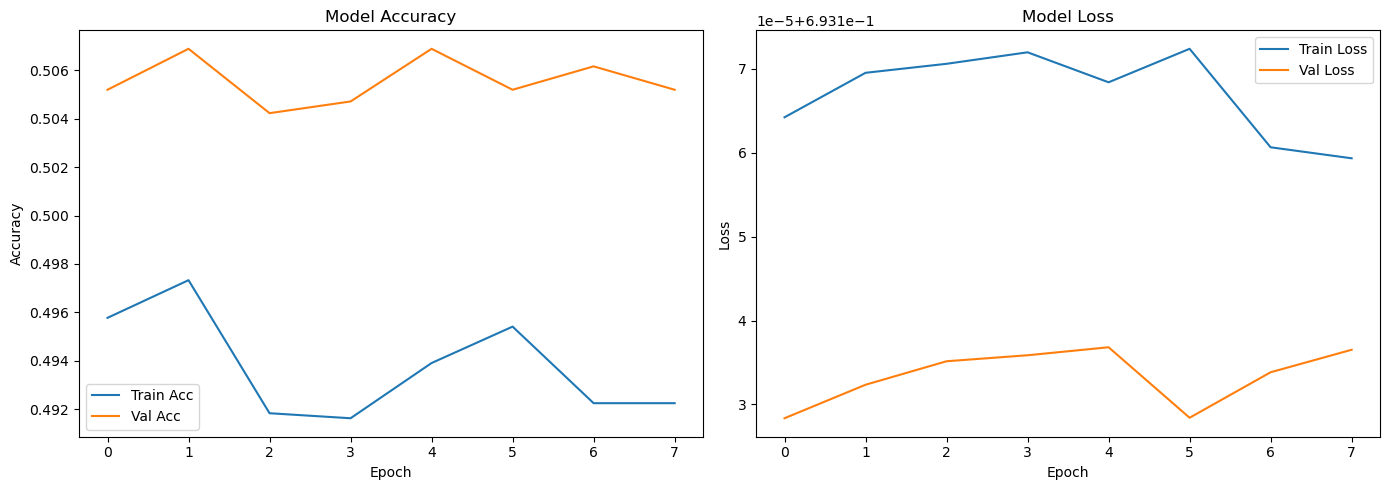

In [23]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Acc')
    ax[0].plot(history.history['val_accuracy'], label='Val Acc')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    
    # Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_tuned)

In [24]:
# Get predictions and true labels
y_true = []
y_pred_prob = []

for images, labels in test_ds:
    preds = tuned_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_prob.extend(preds.flatten())

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)
y_pred = (y_pred_prob > 0.5).astype(int)

In [25]:
# Classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=['Uninfected', 'Parasitized']))

# ROC-AUC
auc = roc_auc_score(y_true, y_pred_prob)
print(f"\nROC-AUC Score: {auc:.4f}")

=== Classification Report ===
              precision    recall  f1-score   support

  Uninfected       0.00      0.00      0.00      2051
 Parasitized       0.50      1.00      0.67      2077

    accuracy                           0.50      4128
   macro avg       0.25      0.50      0.33      4128
weighted avg       0.25      0.50      0.34      4128


ROC-AUC Score: 0.5000


C:\Users\leopo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leopo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leopo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


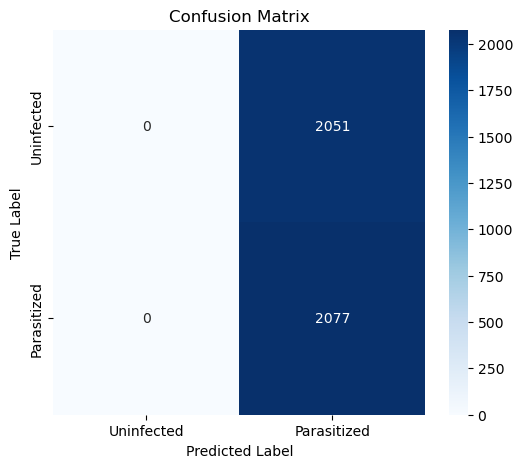

In [26]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

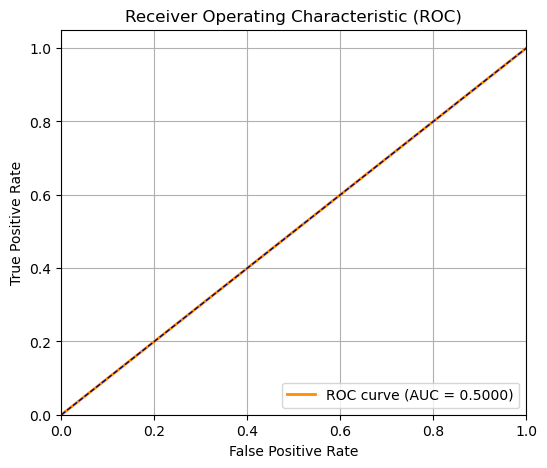

In [27]:
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [28]:
# Save in modern Keras format (.keras) — preferred over .h5
tuned_model.save("models/malaria_cnn_tuned.keras")

# Or if you prefer .h5 (for compatibility)
# tuned_model.save("models/malaria_cnn_tuned.h5")

FileNotFoundError: [Errno 2] No such file or directory: 'models/malaria_cnn_tuned.keras'

In [30]:
import os

# Ensure the 'models' directory exists
os.makedirs("models", exist_ok=True)

# Now save safely
tuned_model.save("models/malaria_cnn_tuned.keras")

In [31]:
import os

# Define absolute path to your models folder
MODEL_DIR = r"C:\Users\leopo\OneDrive\Bureau\UNITY\cell_images\models"
os.makedirs(MODEL_DIR, exist_ok=True)  # Ensure the folder exists

# Save model
tuned_model.save(os.path.join(MODEL_DIR, "malaria_cnn_tuned.keras"))
print("✅ Model saved successfully.")

✅ Model saved successfully.


In [32]:
import tensorflow as tf
import os

MODEL_DIR = r"C:\Users\leopo\OneDrive\Bureau\UNITY\cell_images\models"
model_path = os.path.join(MODEL_DIR, "malaria_cnn_tuned.keras")

# Reload to confirm it works
loaded_model = tf.keras.models.load_model(model_path)
print("✅ Keras model reloaded successfully.")
loaded_model.summary()

✅ Keras model reloaded successfully.


Model: "malaria_cnn_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329,669 (1.26 MB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 219,780 (858.52 KB)

In [33]:
import tf2onnx
import onnx

# Define input signature (must match training: 128x128 RGB)
input_spec = (tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input"),)

# Convert
onnx_model, _ = tf2onnx.convert.from_keras(
    loaded_model,
    input_signature=input_spec,
    opset=13  # Compatible with Unity Barracuda
)

# Save ONNX file
onnx_path = os.path.join(MODEL_DIR, "malaria_cnn_tuned.onnx")
onnx.save(onnx_model, onnx_path)
print(f"✅ ONNX model saved to: {onnx_path}")

ModuleNotFoundError: No module named 'tf2onnx'

In [1]:
# After creating train_ds
class_names = train_ds.class_names
print("Class names (in order):", class_names)
print("Class 0 =", class_names[0])
print("Class 1 =", class_names[1])

NameError: name 'train_ds' is not defined

In [3]:
import tensorflow as tf

# Recreate a minimal version of the dataset just to get class names
data_dir = r"C:\Users\leopo\OneDrive\Bureau\UNITY\cell_images"

# Use the same parameters as before
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',  # or 'int' — but 'binary' gives 0/1
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42,
    shuffle=True
)

class_names = temp_ds.class_names
print("✅ Class names (alphabetical order):", class_names)
print("➡️ Class 0 =", class_names[0])
print("➡️ Class 1 =", class_names[1])

# Optional: show what binary labels mean
print("\n💡 In 'binary' mode:")
print(f"   {class_names[0]} → label 0")
print(f"   {class_names[1]} → label 1")

Found 27558 files belonging to 2 classes.
Using 19291 files for training.
✅ Class names (alphabetical order): ['Parasitized', 'Uninfected']
➡️ Class 0 = Parasitized
➡️ Class 1 = Uninfected

💡 In 'binary' mode:
   Parasitized → label 0
   Uninfected → label 1


In [4]:
import tensorflow as tf
import numpy as np

# === 1. Reload dataset cleanly ===
data_dir = r"C:\Users\leopo\OneDrive\Bureau\UNITY\cell_images"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="training",
    seed=42,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.3,
    subset="validation",
    seed=42,
    shuffle=True
)

# Normalize pixel values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# === 2. Build a simple CNN (no augmentation, no dropout yet) ===
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Found 27558 files belonging to 2 classes.
Using 19291 files for training.
Found 27558 files belonging to 2 classes.
Using 8267 files for validation.


C:\Users\leopo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train for 5 epochs to test learning
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 547s 901ms/step - accuracy: 0.6912 - loss: 0.5980 - val_accuracy: 0.8521 - val_loss: 0.4036
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 523s 836ms/step - accuracy: 0.8727 - loss: 0.3817 - val_accuracy: 0.9025 - val_loss: 0.3570
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 699s 1s/step - accuracy: 0.8782 - loss: 0.3607 - val_accuracy: 0.9181 - val_loss: 0.3598
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 474s 717ms/step - accuracy: 0.8888 - loss: 0.3368 - val_accuracy: 0.9198 - val_loss: 0.3376
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 446s 723ms/step - accuracy: 0.8850 - loss: 0.3352 - val_accuracy: 0.9187 - val_loss: 0.3236


In [6]:
import os

MODEL_DIR = r"C:\Users\leopo\OneDrive\Bureau\UNITY\models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save Keras model
model.save(os.path.join(MODEL_DIR, "malaria_cnn_final.keras"))
print("✅ Final model saved!")

✅ Final model saved!


ModuleNotFoundError: No module named 'tf2onnx'